In [17]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import math
import random
import timeit

In [22]:
# 1.2 plot

def plot_lines(img, lines):
    res = img.copy()
    if lines is None:
        return res
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = rho * a
        y0 = rho * b
        pt1 = (int(x0 + 10000 * (-b)), int(y0 + 10000 * (a)))
        pt2 = (int(x0 - 10000 * (-b)), int(y0 - 10000 * (a)))
        cv.line(res, pt1, pt2, (0, 0, 255), 3, cv.LINE_AA)
    return res


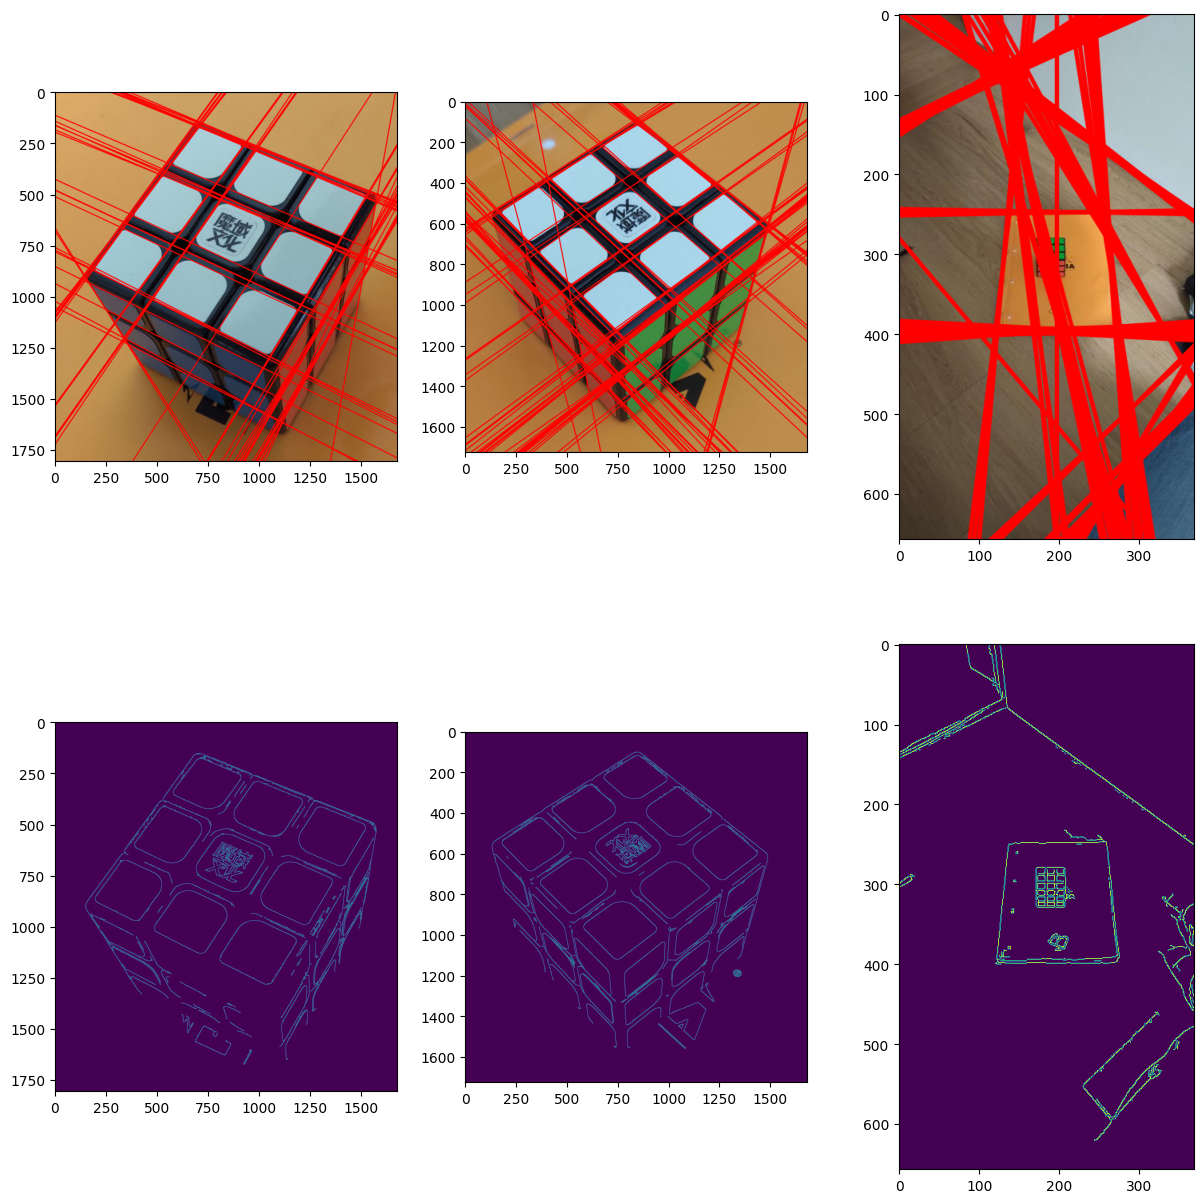

In [73]:
im1 = cv.imread('data/rubik1.jpg')
im2 = cv.imread('data/rubik2.jpg')
im3 = cv.imread('data/rubik5.jpg')

# 1.1 Hougs transform

canny_edge_1 = cv.Canny(im1, 50, 200, None, 3)
canny_edge_2 = cv.Canny(im2, 50, 200, None, 3)
canny_edge_3 = cv.Canny(im3, 50, 200, None, 3)

im1l = cv.HoughLines(canny_edge_1, 1, np.pi / 180.0, 150)
im2l = cv.HoughLines(canny_edge_2, 1, np.pi / 180.0, 150)
im3l = cv.HoughLines(canny_edge_3, 1, np.pi / 180.0, 50)

im1l = plot_lines(im1, im1l)
im2l = plot_lines(im2, im2l)
im3l = plot_lines(im3, im3l)


im1l = cv.cvtColor(im1l, cv.COLOR_BGR2RGB)
im2l = cv.cvtColor(im2l, cv.COLOR_BGR2RGB)
im3l = cv.cvtColor(im3l, cv.COLOR_BGR2RGB)

row = 2
col = 3
i = 1
plt.figure(figsize=(15, 15))
plt.subplot(row, col, i), plt.imshow(im1l)
i+=1
plt.subplot(row, col, i), plt.imshow(im2l)
i+=1
plt.subplot(row, col, i), plt.imshow(im3l)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_1)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_2)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_3)
i+=1
plt.show()

# A. Computing vanishing points: questions

## 1. The number of vanishing points

Between 0 and 3 finite vanishing points can be found from all possible images of a Rubik's cube. This is because our 3D world, once projected onto a 2D photography only has 3 degrees of freedom for the viewpoint: Left and right, up and down, forward and backward.

For the minimum, the least you can have is 0
- When you take a really zoomed in picture (inside a green square for exemple with no edge visible) because there will be no parallel lines. 
- When you take a perfect picture of a single face like a 2D square, because the lines on the Rubik's Cube will be parallel and will have the same depth (to the camera), the lines projected onto the image in 2D will be perfectly parallel and will never intersect to give vanishing points.

But for a more realistic picture where you can see only one whole face, there will be probably a rotation so, even if it will be a 2d square with only x and y axis, thoses axis parallel lines will converge to a single point per axis event if it is really far, giving 2 vanishing points.





## 2.
Yes, there will be one vanishing point per axis

## 3. 

No, we will never be able to find a 4th vanishing point because the photo takes a 3D image (our world) onto a 2D image, so there are only 3 axes to be deformed by the perspective which means that we will only be able to fid 3 vanishing points at most. That's only 

If you change perspective to deform parallels (like a fish eye camera) you may be able to find more than 3 vanishing points, because line will become curved and will be able to intersect more than 3 times. this is not possible with a normal camera, but specialized fish eye cameras can do that and you will be able to find <a src="https://ieeexplore.ieee.org/document/5190078">4 vanishing points.</a>

²## 4.

Vanishing points can be outside of the image. Take the following picture for example:

<img src="data/rubik4.jpg" width="200"></img>